In [6]:
import torch
import torchvision
import datasets, networks, sampling, evaluation
import matplotlib.pyplot as plt
from torch import nn, optim

In [7]:
# HYPERPARAMETERS
num_epochs = 10 


# TODO Select a batch size.
batch_size = 64


# TODO Select a learning rate.
lr= 0.005


num_units=4000
num_layer=4

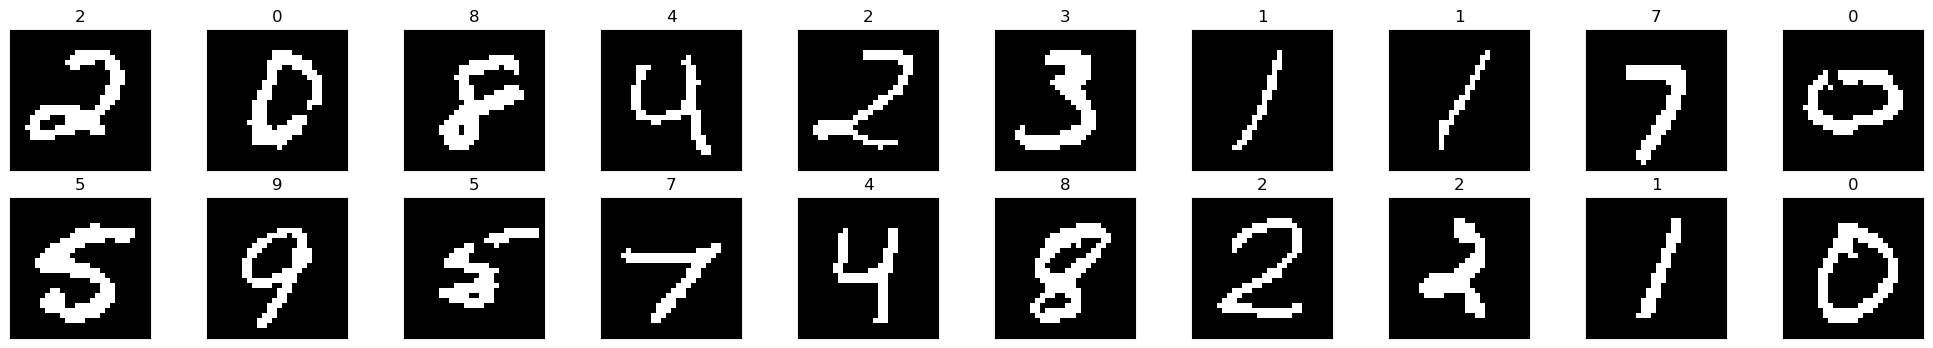

In [8]:
# Create Dataset/Data Loaders and visualize Dataset
Ds = datasets.Dataset('mnist', batch_size=batch_size)
training_data = Ds.get_train_data_loader()
test_data = Ds.get_test_data_loader()

Ds.visualize_dataset(training_data)


ordering=range(1,785) 

Using device: cuda:0
Epoch:   1/ 10, Batch     1, Loss: 0.6929
Epoch:   1/ 10, Batch   101, Loss: 0.2667
Epoch:   1/ 10, Batch   201, Loss: 0.2153
Epoch:   1/ 10, Batch   301, Loss: 0.1940
Epoch:   1/ 10, Batch   401, Loss: 0.1827
Epoch:   1/ 10, Batch   501, Loss: 0.1752
Epoch:   1/ 10, Batch   601, Loss: 0.1679
Epoch:   1/ 10, Batch   701, Loss: 0.1619
Epoch:   1/ 10, Batch   801, Loss: 0.1585
Epoch:   1/ 10, Batch   901, Loss: 0.1556
-----------------------------------------
Epoch:   1 took 14.77s
Epoch:   1, Test Loss: 0.1514
-----------------------------------------


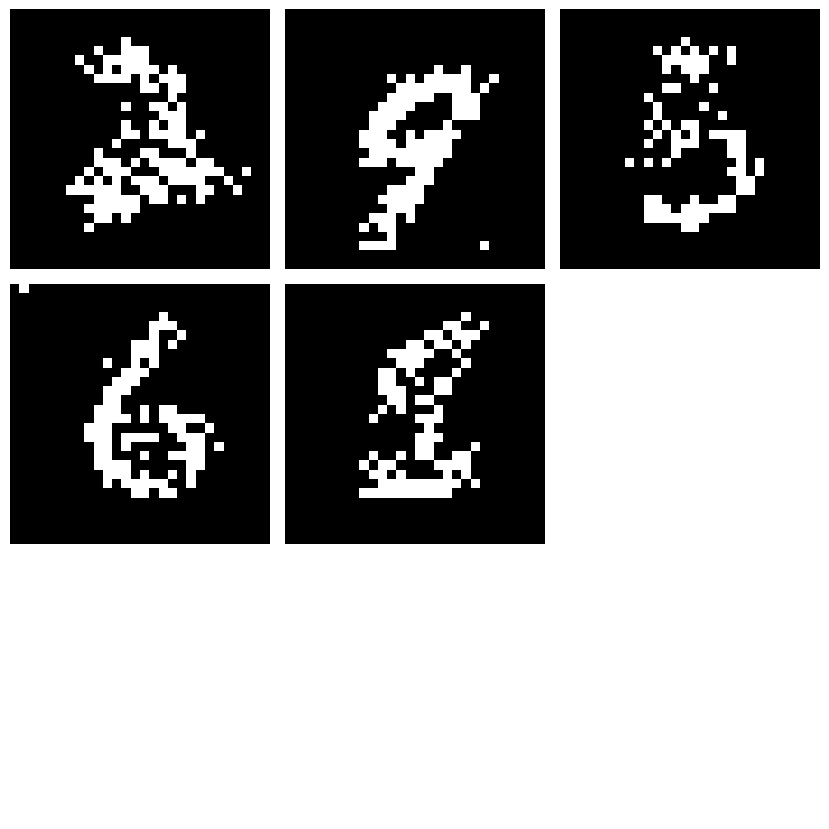

Epoch:   2/ 10, Batch     1, Loss: 0.1495
Epoch:   2/ 10, Batch   101, Loss: 0.1495
Epoch:   2/ 10, Batch   201, Loss: 0.1475
Epoch:   2/ 10, Batch   301, Loss: 0.1459
Epoch:   2/ 10, Batch   401, Loss: 0.1455
Epoch:   2/ 10, Batch   501, Loss: 0.1440
Epoch:   2/ 10, Batch   601, Loss: 0.1423
Epoch:   2/ 10, Batch   701, Loss: 0.1405
Epoch:   2/ 10, Batch   801, Loss: 0.1401
Epoch:   2/ 10, Batch   901, Loss: 0.1389
-----------------------------------------
Epoch:   2 took 14.85s
Epoch:   2, Test Loss: 0.1390
-----------------------------------------


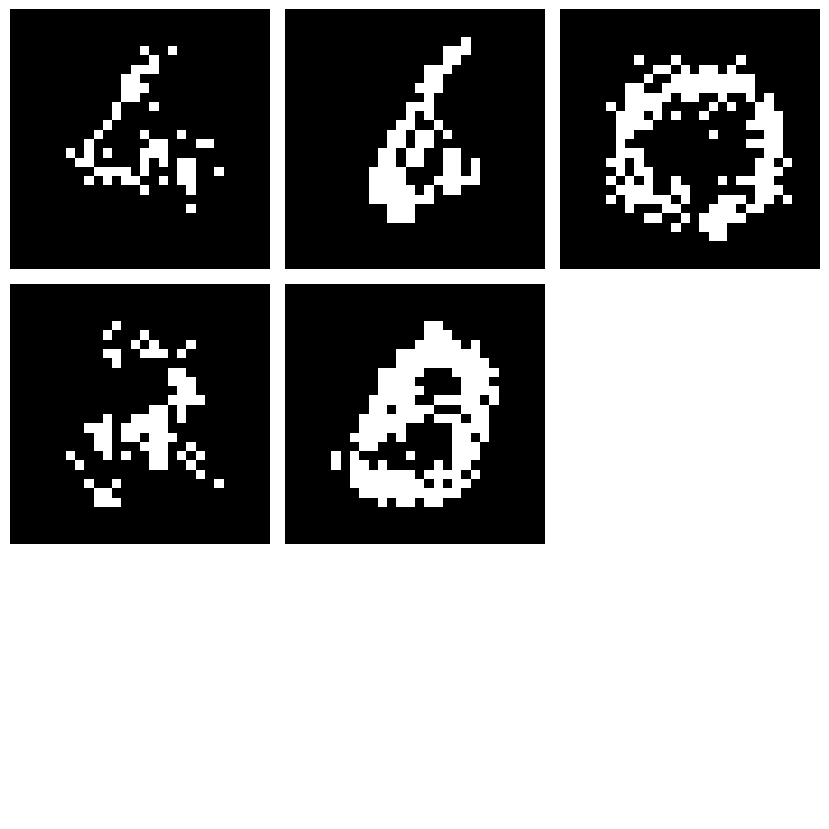

Epoch:   3/ 10, Batch     1, Loss: 0.1431
Epoch:   3/ 10, Batch   101, Loss: 0.1344
Epoch:   3/ 10, Batch   201, Loss: 0.1351
Epoch:   3/ 10, Batch   301, Loss: 0.1360
Epoch:   3/ 10, Batch   401, Loss: 0.1361
Epoch:   3/ 10, Batch   501, Loss: 0.1337
Epoch:   3/ 10, Batch   601, Loss: 0.1342
Epoch:   3/ 10, Batch   701, Loss: 0.1343
Epoch:   3/ 10, Batch   801, Loss: 0.1334
Epoch:   3/ 10, Batch   901, Loss: 0.1331
-----------------------------------------
Epoch:   3 took 14.87s
Epoch:   3, Test Loss: 0.1327
-----------------------------------------


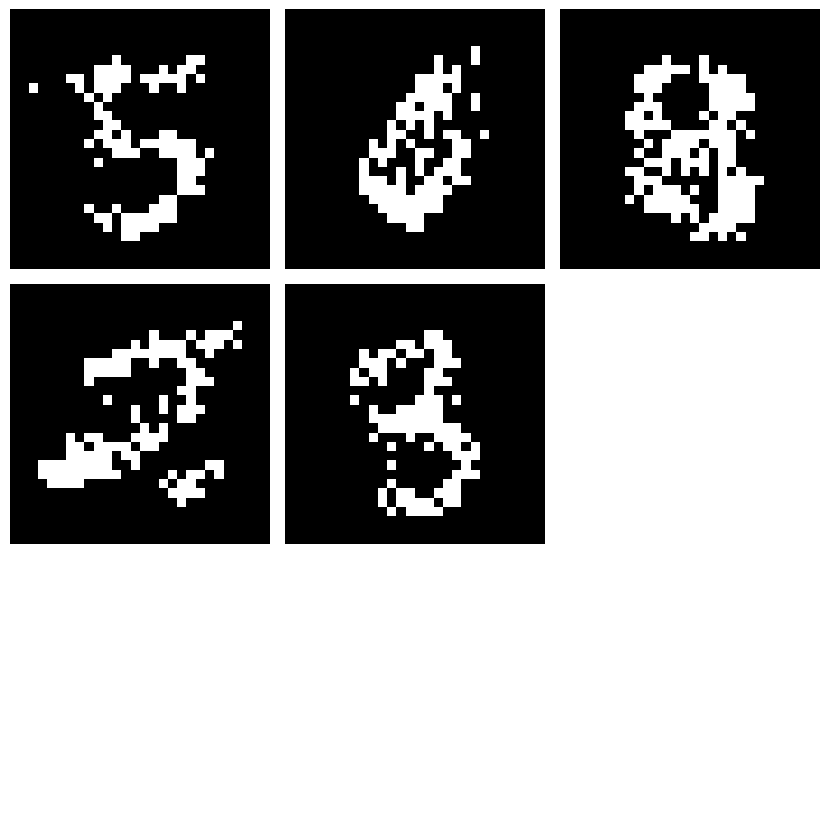

Epoch:   4/ 10, Batch     1, Loss: 0.1417
Epoch:   4/ 10, Batch   101, Loss: 0.1294
Epoch:   4/ 10, Batch   201, Loss: 0.1295
Epoch:   4/ 10, Batch   301, Loss: 0.1298
Epoch:   4/ 10, Batch   401, Loss: 0.1306
Epoch:   4/ 10, Batch   501, Loss: 0.1299
Epoch:   4/ 10, Batch   601, Loss: 0.1304
Epoch:   4/ 10, Batch   701, Loss: 0.1304
Epoch:   4/ 10, Batch   801, Loss: 0.1297
Epoch:   4/ 10, Batch   901, Loss: 0.1286
-----------------------------------------
Epoch:   4 took 14.30s
Epoch:   4, Test Loss: 0.1300
-----------------------------------------


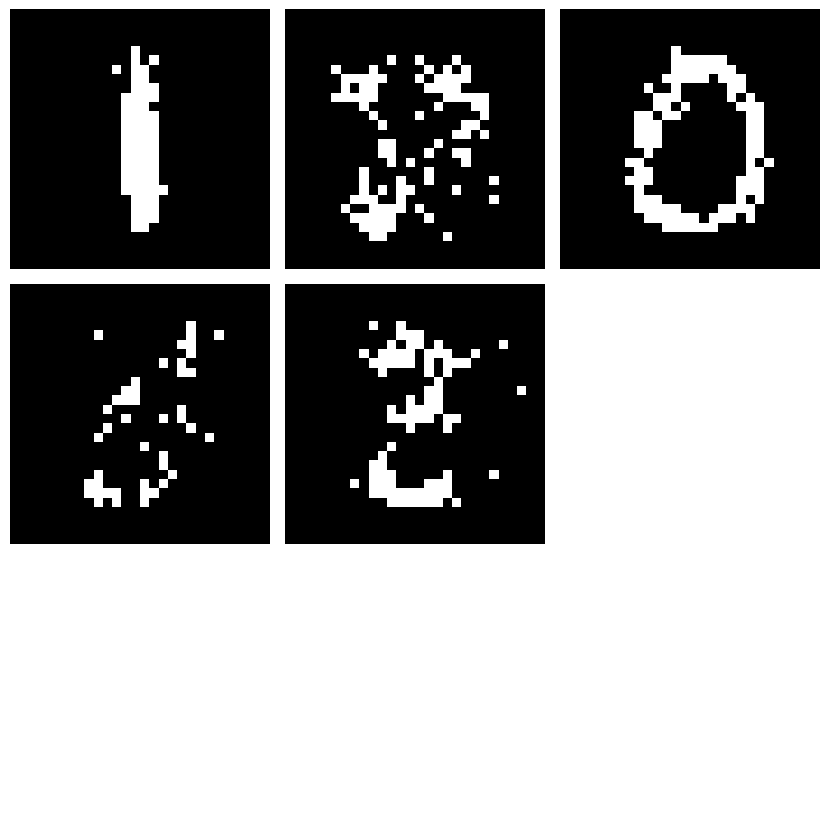

Epoch:   5/ 10, Batch     1, Loss: 0.1271
Epoch:   5/ 10, Batch   101, Loss: 0.1262
Epoch:   5/ 10, Batch   201, Loss: 0.1271
Epoch:   5/ 10, Batch   301, Loss: 0.1269
Epoch:   5/ 10, Batch   401, Loss: 0.1265
Epoch:   5/ 10, Batch   501, Loss: 0.1261
Epoch:   5/ 10, Batch   601, Loss: 0.1269
Epoch:   5/ 10, Batch   701, Loss: 0.1273
Epoch:   5/ 10, Batch   801, Loss: 0.1280
Epoch:   5/ 10, Batch   901, Loss: 0.1273
-----------------------------------------
Epoch:   5 took 14.29s
Epoch:   5, Test Loss: 0.1283
-----------------------------------------


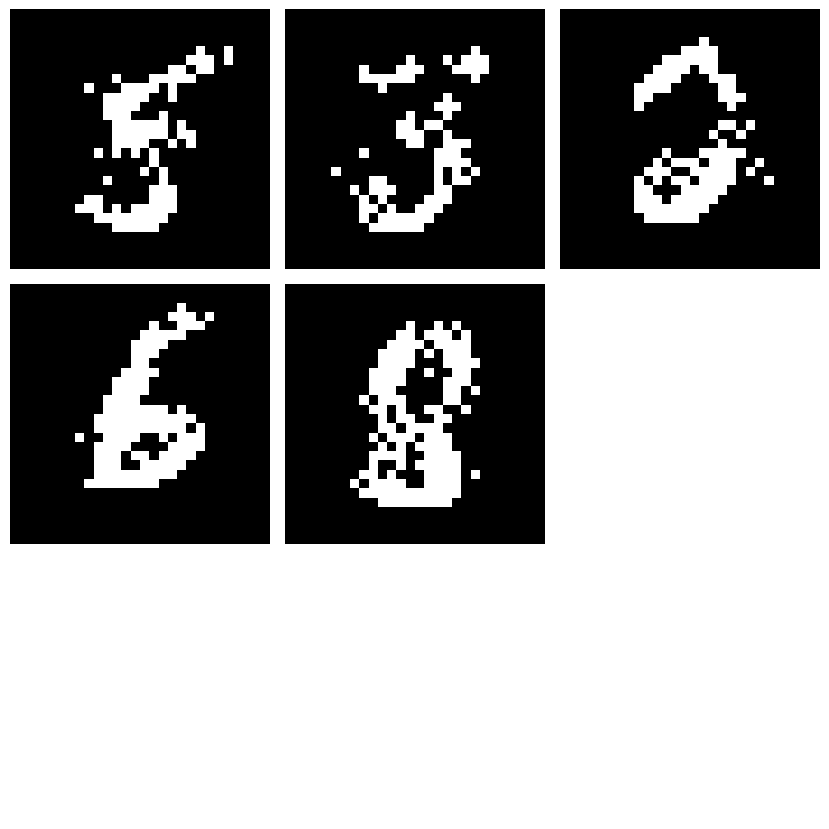

Epoch:   6/ 10, Batch     1, Loss: 0.1184
Epoch:   6/ 10, Batch   101, Loss: 0.1239
Epoch:   6/ 10, Batch   201, Loss: 0.1247
Epoch:   6/ 10, Batch   301, Loss: 0.1244
Epoch:   6/ 10, Batch   401, Loss: 0.1244
Epoch:   6/ 10, Batch   501, Loss: 0.1253
Epoch:   6/ 10, Batch   601, Loss: 0.1251
Epoch:   6/ 10, Batch   701, Loss: 0.1252
Epoch:   6/ 10, Batch   801, Loss: 0.1257
Epoch:   6/ 10, Batch   901, Loss: 0.1248
-----------------------------------------
Epoch:   6 took 14.32s
Epoch:   6, Test Loss: 0.1267
-----------------------------------------


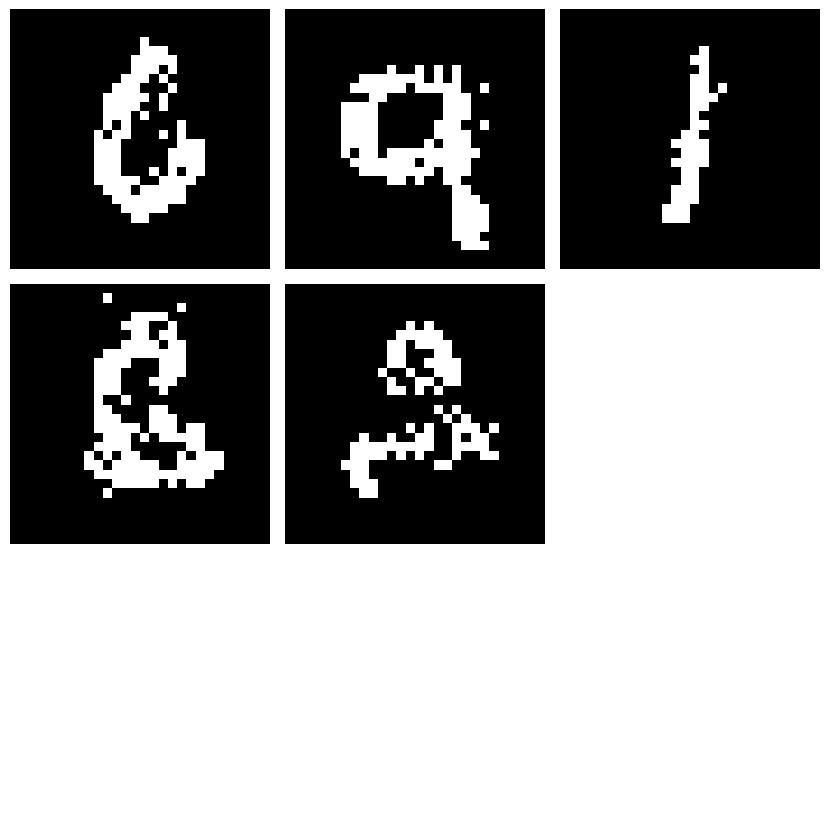

Epoch:   7/ 10, Batch     1, Loss: 0.1158
Epoch:   7/ 10, Batch   101, Loss: 0.1226
Epoch:   7/ 10, Batch   201, Loss: 0.1232
Epoch:   7/ 10, Batch   301, Loss: 0.1239
Epoch:   7/ 10, Batch   401, Loss: 0.1219
Epoch:   7/ 10, Batch   501, Loss: 0.1241
Epoch:   7/ 10, Batch   601, Loss: 0.1234
Epoch:   7/ 10, Batch   701, Loss: 0.1241
Epoch:   7/ 10, Batch   801, Loss: 0.1244
Epoch:   7/ 10, Batch   901, Loss: 0.1231
-----------------------------------------
Epoch:   7 took 14.36s
Epoch:   7, Test Loss: 0.1273
-----------------------------------------


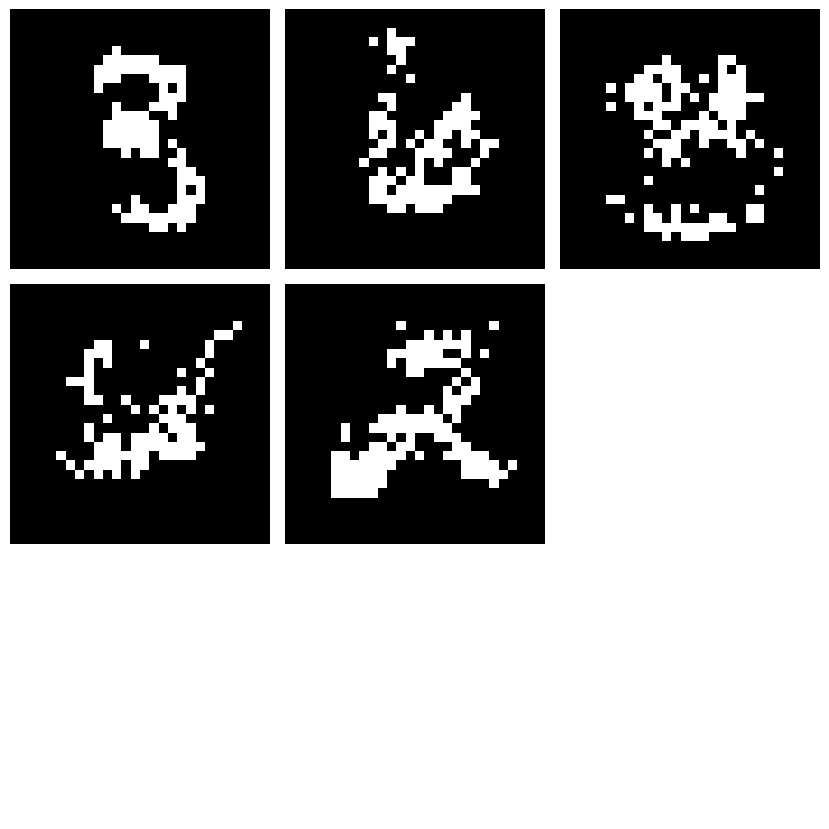

Epoch:   8/ 10, Batch     1, Loss: 0.1185
Epoch:   8/ 10, Batch   101, Loss: 0.1212
Epoch:   8/ 10, Batch   201, Loss: 0.1205
Epoch:   8/ 10, Batch   301, Loss: 0.1221
Epoch:   8/ 10, Batch   401, Loss: 0.1212
Epoch:   8/ 10, Batch   501, Loss: 0.1223
Epoch:   8/ 10, Batch   601, Loss: 0.1223
Epoch:   8/ 10, Batch   701, Loss: 0.1220
Epoch:   8/ 10, Batch   801, Loss: 0.1241
Epoch:   8/ 10, Batch   901, Loss: 0.1234
-----------------------------------------
Epoch:   8 took 14.24s
Epoch:   8, Test Loss: 0.1262
-----------------------------------------


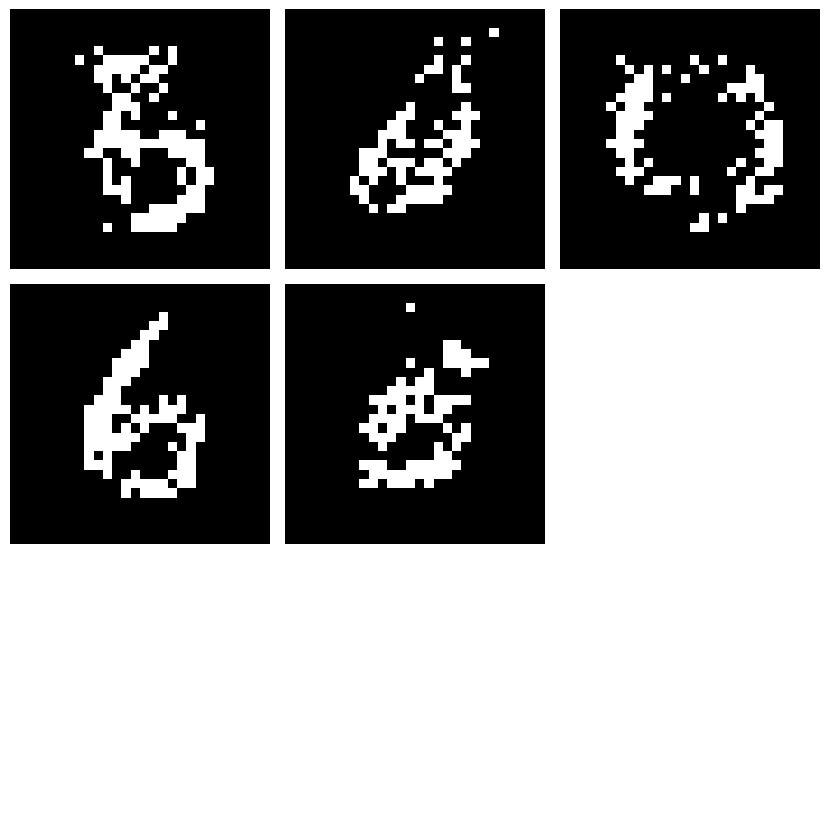

Epoch:   9/ 10, Batch     1, Loss: 0.1135
Epoch:   9/ 10, Batch   101, Loss: 0.1202
Epoch:   9/ 10, Batch   201, Loss: 0.1198
Epoch:   9/ 10, Batch   301, Loss: 0.1214
Epoch:   9/ 10, Batch   401, Loss: 0.1206
Epoch:   9/ 10, Batch   501, Loss: 0.1210
Epoch:   9/ 10, Batch   601, Loss: 0.1219
Epoch:   9/ 10, Batch   701, Loss: 0.1219
Epoch:   9/ 10, Batch   801, Loss: 0.1222
Epoch:   9/ 10, Batch   901, Loss: 0.1217
-----------------------------------------
Epoch:   9 took 14.10s
Epoch:   9, Test Loss: 0.1260
-----------------------------------------


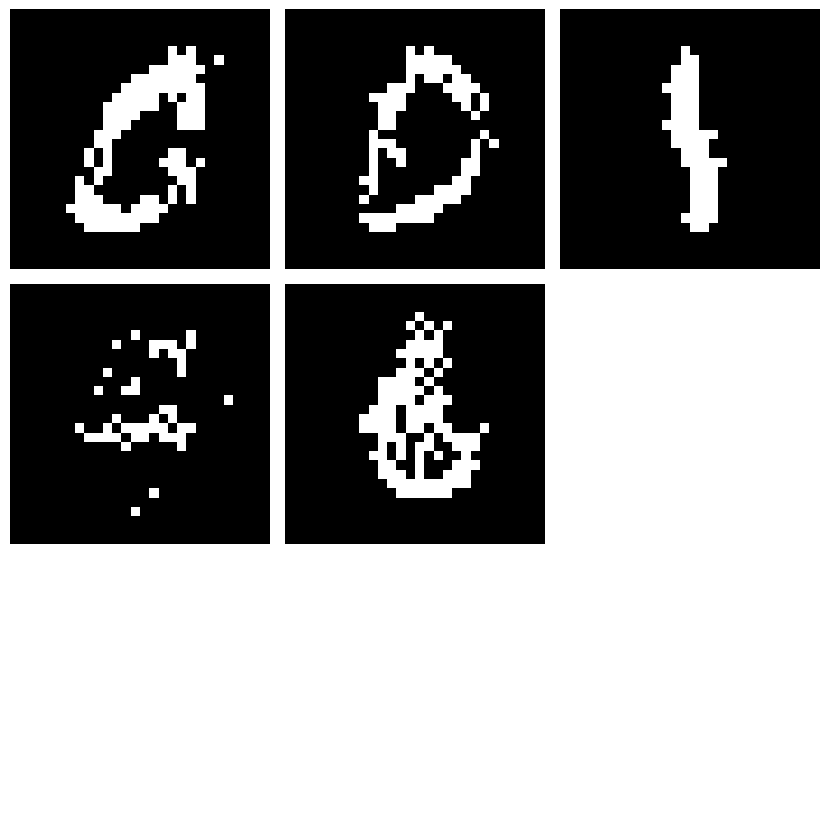

Epoch:  10/ 10, Batch     1, Loss: 0.1167
Epoch:  10/ 10, Batch   101, Loss: 0.1190
Epoch:  10/ 10, Batch   201, Loss: 0.1200
Epoch:  10/ 10, Batch   301, Loss: 0.1204
Epoch:  10/ 10, Batch   401, Loss: 0.1211
Epoch:  10/ 10, Batch   501, Loss: 0.1205
Epoch:  10/ 10, Batch   601, Loss: 0.1208
Epoch:  10/ 10, Batch   701, Loss: 0.1197
Epoch:  10/ 10, Batch   801, Loss: 0.1208
Epoch:  10/ 10, Batch   901, Loss: 0.1205
-----------------------------------------
Epoch:  10 took 14.10s
Epoch:  10, Test Loss: 0.1250
-----------------------------------------


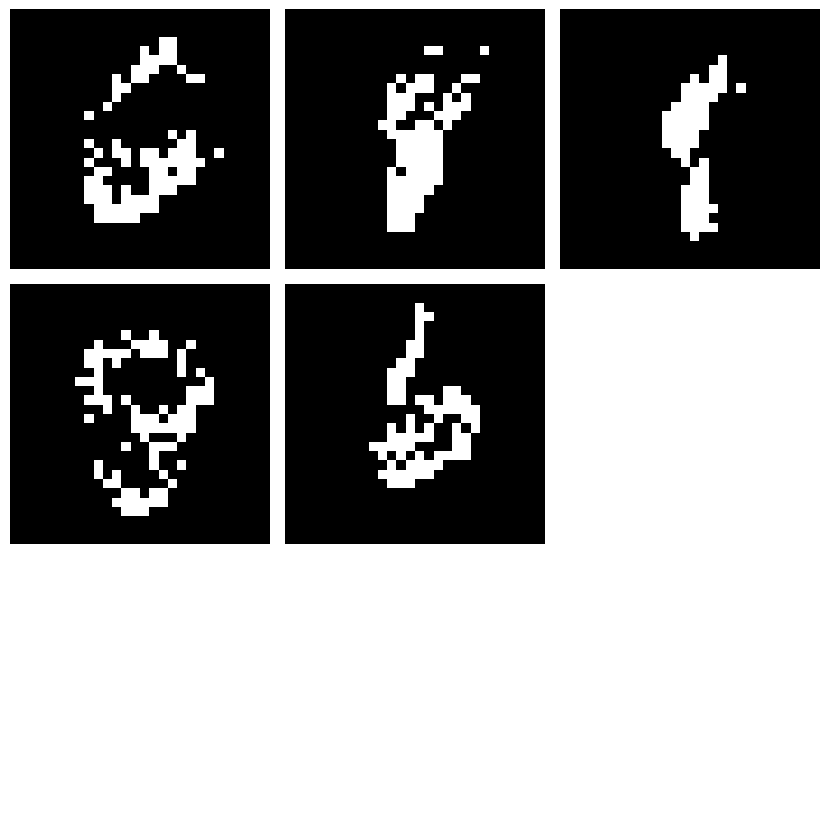

Training took 176.82s


In [9]:
import time
# Training

MADE = networks.MADE(num_layer=num_layer, num_units=num_units, ordering=ordering, input_feat=28*28)

# Select device
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')
print(f'Using device: {device}')
print('=========================================')

MADE.to(device)

loss_curve = []
accuracy_curve = []
epoch_markers = []
optimizer= torch.optim.Adam(MADE.parameters(),lr)

overall_start_time = time.time()

for epoch in range(num_epochs):

  epoch_start_time = time.time()
  # Switch to training mode.
  MADE.train()

  losses = []
  batch_idx = 0

  for images, labels in training_data:

    images = images.to(device)

    output = MADE(images)
    loss = nn.functional.binary_cross_entropy(output,images)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()


    losses.append(loss.detach().clone())

    if batch_idx % 100 == 0:
      average_loss = torch.stack(losses).mean().item()
      loss_curve.append(average_loss)
      losses = []
      print(f'Epoch: {epoch + 1:3d}/{num_epochs:3d}, Batch {batch_idx + 1:5d}, Loss: {average_loss:.4f}')
    batch_idx += 1

  epoch_end_time = time.time()
  print('-----------------------------------------')
  print(f'Epoch: {epoch + 1:3d} took {epoch_end_time - epoch_start_time:.2f}s')
  print(f'Epoch: {epoch + 1:3d}, Test Loss: {evaluation.evaluate(model = MADE,test_data_loader = test_data, device = device):.4f}')
  print('-----------------------------------------')
  

  samples = sampling.sample(MADE, num_samples=5)
  sampling.save_samples(samples)

  

overall_end_time = time.time()
print('=========================================')
print(f'Training took {overall_end_time - overall_start_time:.2f}s')

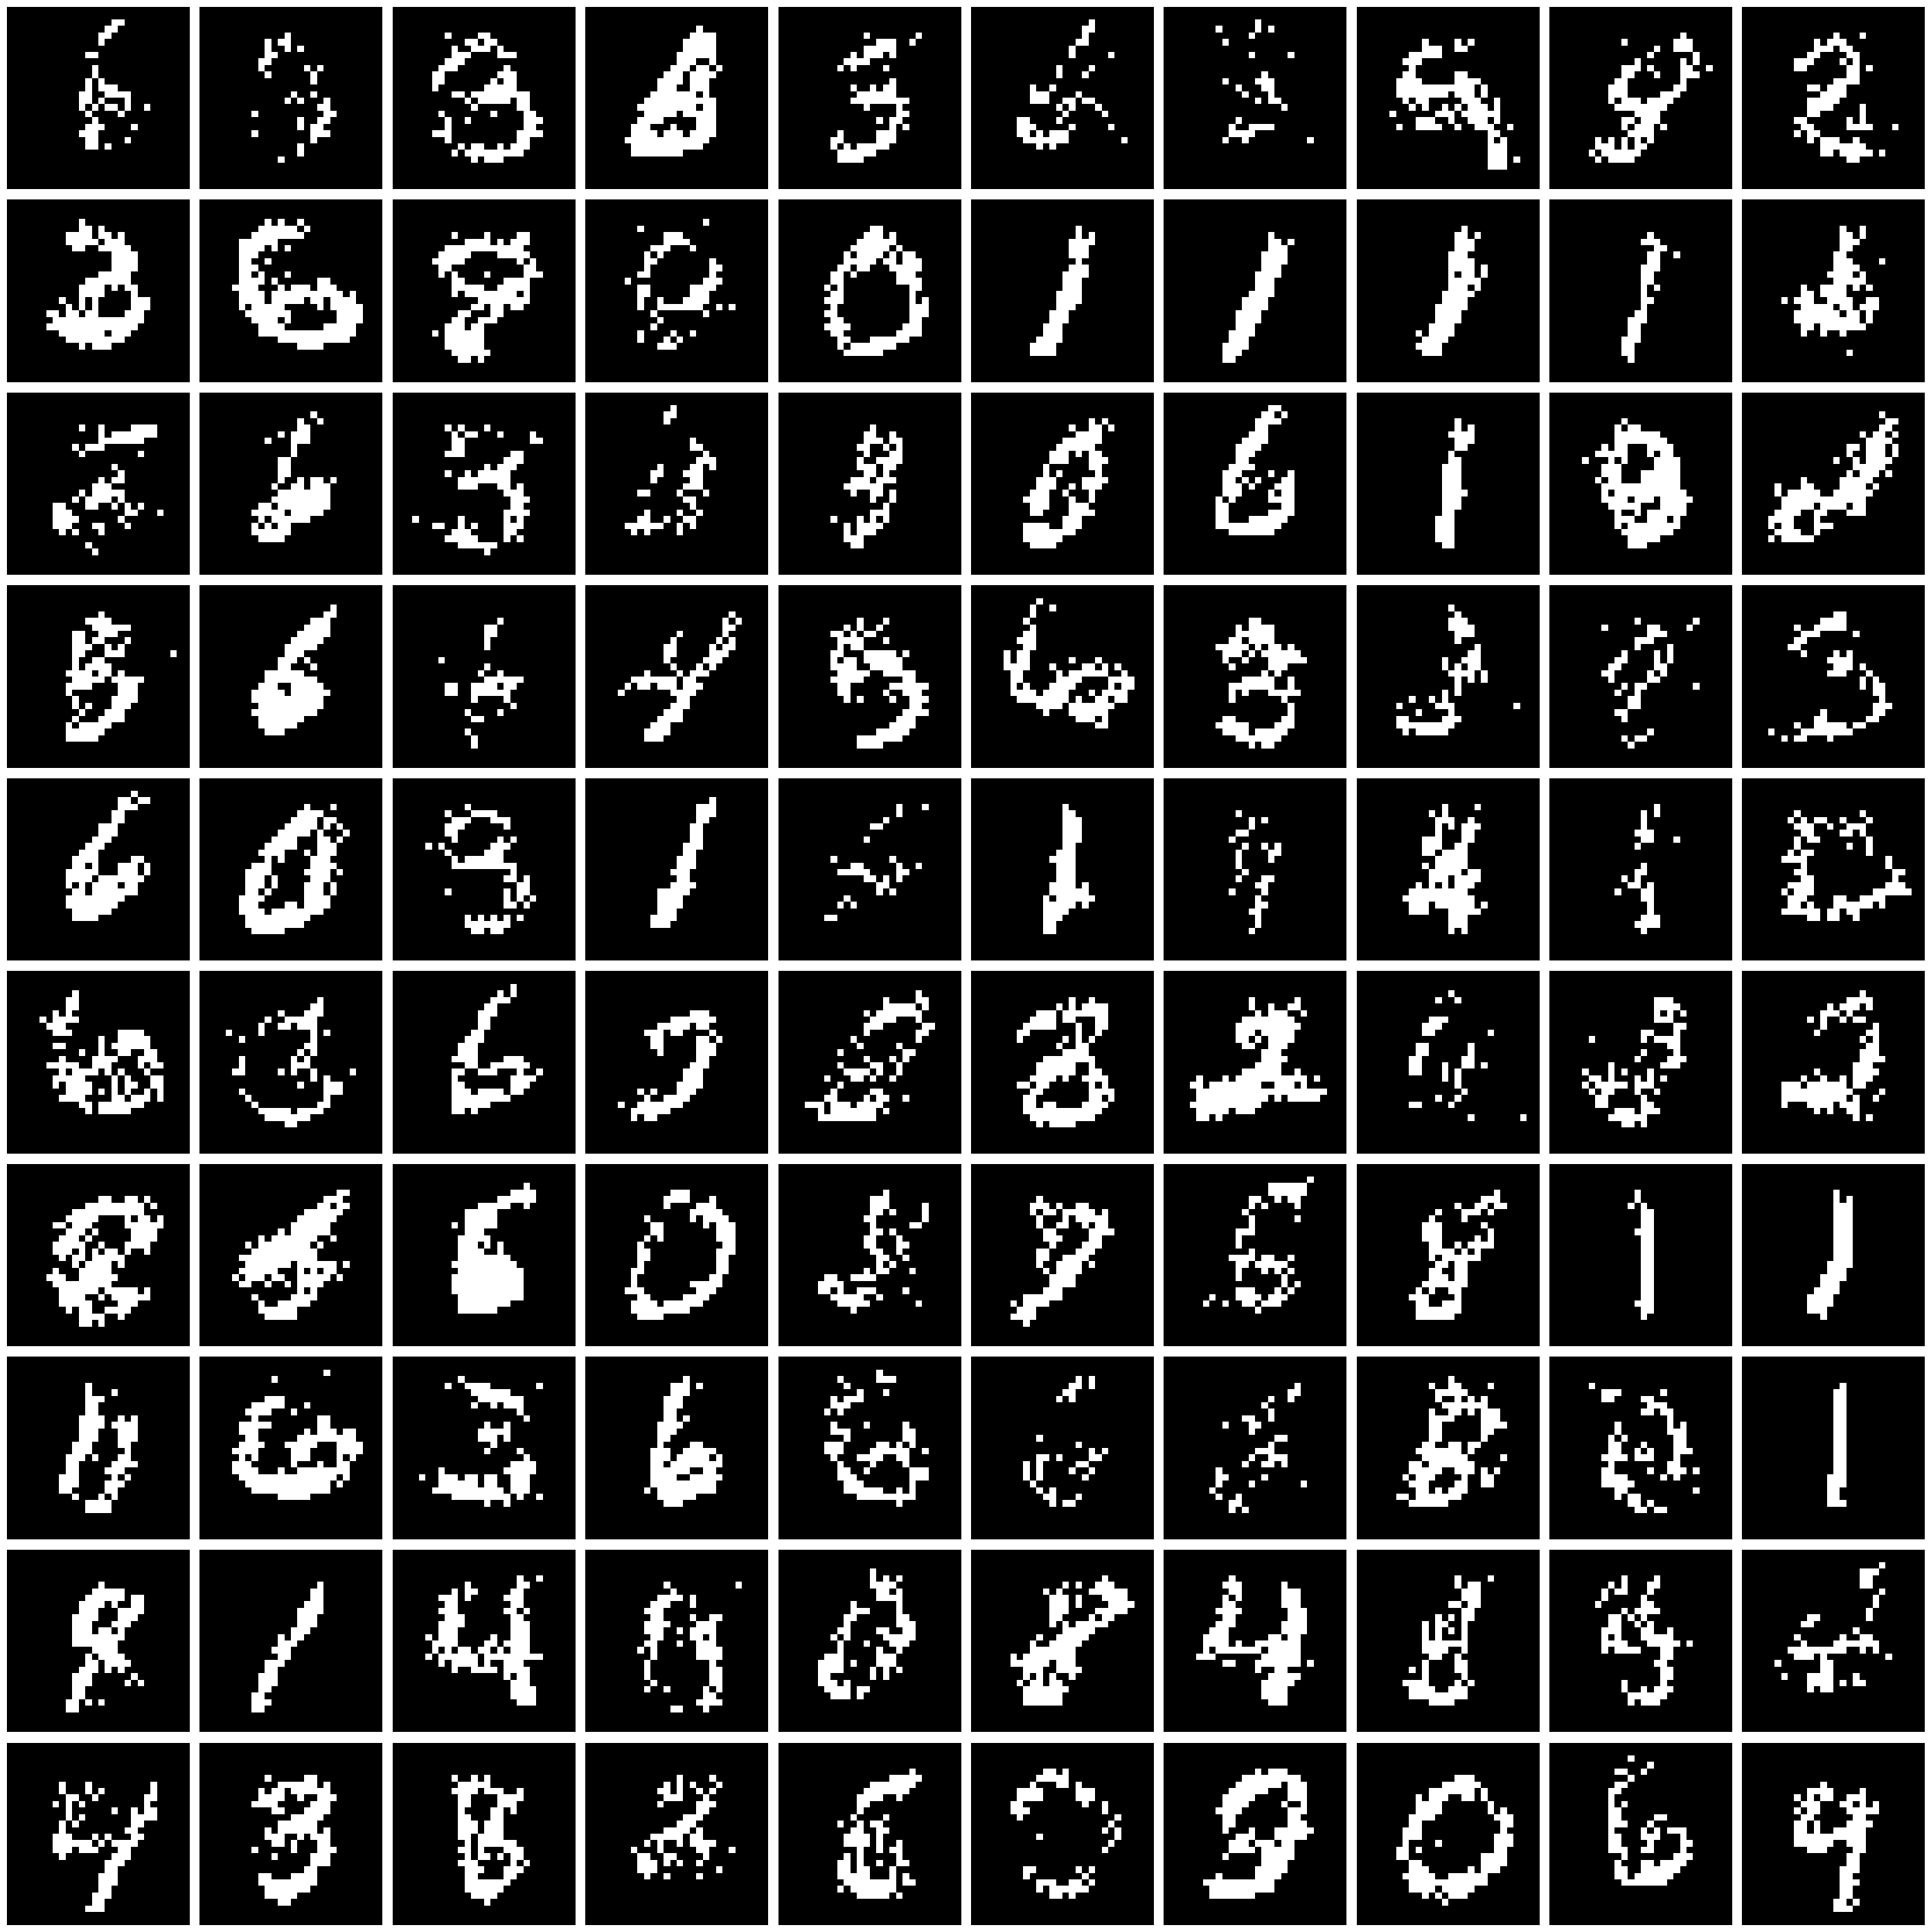

In [10]:
final_samples= sampling.sample(MADE, num_samples=100)
sampling.save_samples(final_samples)